โค้ดนี้ดีแล้ว แต่ต้องลบ find-tune เพราะมันมั่ว

In [17]:
"""
train_pipeline_eye.py

- อ่านภาพหลายขนาดและไฟล์ .txt ที่เก็บจุดกึ่งกลาง (x y)
- ปรับขนาดภาพเป็น 144x144 และ scale พิกัดให้ตรง
- สร้าง augmentation (albumentations) ที่แปลง keypoint (x,y)
- สร้าง CNN regressor (MobileNetV2 backbone) -> predict (x,y) ใน pixel
- สกัด feature จาก backbone -> train RandomForest & XGBoost
- ประเมิน MAE (pixel) บน test set
- บันทึกโมเดลที่ดีที่สุด
"""
import os, glob, math, random
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # ตั้งให้ TensorFlow ใช้ GPU memory แบบ dynamic (ไม่กินเต็ม GPU)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU ready")
    except RuntimeError as e:
        print(e)

# -------------------------
# Config
# -------------------------
IMAGE_DIR = "./../data/Right/Image224x224"            # ปรับพาธให้ตรง
ANNO_DIR = "./../data/Right/Annotation224x224"        # ปรับพาธให้ตรง
IMG_SIZE = (144, 144)
RANDOM_SEED = 42
TEST_SIZE = 0.10
VAL_SIZE = 0.10
BATCH_SIZE = 32
EPOCHS = 200
AUG_TIMES = 2   # จำนวน augmentation ต่อภาพในชุด train (ปรับเพิ่มถ้าต้องการ)
USE_GPU = True

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------------
# Helper: อ่าน annotation (robust กับ null bytes และ format ต่างๆ)
# - ถ้าไฟล์มี normalized (0..1) จะ detect และแปลงโดยใช้ image original size
# - ถ้าไฟล์มี 2 ค่าจะถือเป็น center x y (pixel หรือ normalized)
# - ถ้ามี >=4 ตัวจะลองตรวจว่าเป็น YOLO (cx cy w h) normalized หรือ pixel -> ใช้ cx,cy
# -------------------------
def read_txt_safe(txt_path, orig_w=None, orig_h=None):
    # คืนค่า (cx_pixel, cy_pixel) หรือ None
    try:
        with open(txt_path, "rb") as f:
            raw = f.read().replace(b"\x00", b"")
        s = raw.decode("utf-8", errors="ignore").strip()
        if len(s) == 0:
            return None
        parts = s.split()
        nums = []
        for p in parts:
            try:
                nums.append(float(p))
            except:
                pass
        if len(nums) == 0:
            return None
        # If values mostly between 0 and 1 => normalized
        if all(0.0 <= v <= 1.0 for v in nums[:2]) and orig_w and orig_h:
            # treat first two as normalized center
            cx = nums[0] * orig_w
            cy = nums[1] * orig_h
            return cx, cy
        # if first two values are >1 => pixel coords already
        if len(nums) >= 2:
            return float(nums[0]), float(nums[1])
    except Exception as e:
        print("read_txt_safe error:", txt_path, e)
    return None

# -------------------------
# Load dataset: read images, read corresponding .txt
# - We will read original image size to properly convert normalized labels.
# - Resize image to IMG_SIZE and scale coordinates accordingly.
# - Convert to RGB (3-channel) to use pretrained backbone.
# -------------------------
def load_dataset(image_dir, anno_dir):
    img_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
    imgs = []
    coords = []
    used_files = []
    for p in img_paths:
        base = os.path.basename(p)
        name, ext = os.path.splitext(base)
        txt_p = os.path.join(anno_dir, name + ".txt")
        if not os.path.exists(txt_p):
            continue
        # read original to know orig_w, orig_h for normalized detection
        img_orig = cv2.imread(p)
        if img_orig is None:
            continue
        orig_h, orig_w = img_orig.shape[:2]
        xy = read_txt_safe(txt_p, orig_w=orig_w, orig_h=orig_h)
        if xy is None:
            continue
        cx, cy = xy
        # now resize image to IMG_SIZE and scale cx,cy
        img_resized = cv2.resize(img_orig, IMG_SIZE)
        # convert to RGB
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        # scale coords: new_x = cx * (new_w / orig_w)
        new_cx = cx * (IMG_SIZE[0] / orig_w)
        new_cy = cy * (IMG_SIZE[1] / orig_h)
        imgs.append(img_rgb)
        coords.append([new_cx, new_cy])
        used_files.append(base)
    X = np.array(imgs, dtype=np.uint8)
    y = np.array(coords, dtype=np.float32)
    print(f"Loaded {len(X)} images. Example shapes: X {X.shape}, y {y.shape}")
    return X, y, used_files

# -------------------------
# Augmentation pipeline (albumentations) for images + keypoints
# keypoint format: (x, y)
# -------------------------
def get_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=8, p=0.7, border_mode=cv2.BORDER_REFLECT),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
        A.OneOf([A.MotionBlur(blur_limit=3), A.MedianBlur(blur_limit=3), A.Blur(blur_limit=3)], p=0.2),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# -------------------------
# Create augmented dataset (applied only to train set)
# -------------------------
def augment_dataset(X, y, times=1):
    aug = get_augmentations()
    X_aug = []
    y_aug = []
    for i in range(len(X)):
        for t in range(times):
            transformed = aug(image=X[i], keypoints=[tuple(y[i])])
            img_t = transformed['image']
            kps = transformed['keypoints']
            if len(kps) == 0:
                continue
            kp = kps[0]
            # keep within bounds
            cx = min(max(kp[0], 0), IMG_SIZE[0]-1)
            cy = min(max(kp[1], 0), IMG_SIZE[1]-1)
            X_aug.append(img_t)
            y_aug.append([cx, cy])
    if len(X_aug) == 0:
        return X, y
    X_all = np.concatenate([X, np.array(X_aug, dtype=np.uint8)], axis=0)
    y_all = np.concatenate([y, np.array(y_aug, dtype=np.float32)], axis=0)
    print(f"Augmented: added {len(X_aug)} samples -> total {len(X_all)}")
    return X_all, y_all

# -------------------------
# Build CNN regressor using MobileNetV2 backbone
# -------------------------
def build_cnn_regressor(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3)):
    base = applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(2, activation='linear')(x)  # predict (x,y)
    model = models.Model(inputs=base.input, outputs=out)
    # freeze backbone
    for layer in base.layers:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.Huber(),   # robust loss
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model, base

# -------------------------
# Feature extractor (using backbone)
# -------------------------
def extract_features_from_backbone(base_model, X_array, batch_size=32):
    # create a small model from input -> globalpool
    inp = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    feat_model = models.Model(inputs=inp, outputs=x)
    feats = feat_model.predict(X_array, batch_size=batch_size, verbose=1)
    return feats

tf.debugging.set_log_device_placement(True)

In [18]:
# -------------------------
# Load dataset
# -------------------------
X, y, files = load_dataset(IMAGE_DIR, ANNO_DIR)
if len(X) == 0:
    print("No data loaded. Check paths.")
    exit()
# train/test/val split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=RANDOM_SEED)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)
# Augmentation
X_train_aug, y_train_aug = augment_dataset(X_train, y_train, times=AUG_TIMES)
# Preprocess for Keras: scale to [0,1]
X_train_norm = X_train_aug.astype(np.float32)/255.0
X_val_norm   = X_val.astype(np.float32)/255.0
X_test_norm  = X_test.astype(np.float32)/255.0


Loaded 5554 images. Example shapes: X (5554, 144, 144, 3), y (5554, 2)
Splits: (4442, 144, 144, 3) (556, 144, 144, 3) (556, 144, 144, 3)


C:\Users\ahmad\AppData\Local\Temp\ipykernel_15180\2222708432.py:141: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),


Augmented: added 8884 samples -> total 13326


In [19]:
# -------------------------
# Build CNN
# -------------------------
cnn, backbone = build_cnn_regressor(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3))
cnn.summary()
es = callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=15, restore_best_weights=True, mode='min', verbose=1)
mc = callbacks.ModelCheckpoint("best_cnn.h5", monitor="val_mean_absolute_error", save_best_only=True, mode='min', verbose=1)
rl = callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
# Train CNN
print("Training CNN with frozen backbone")
history = cnn.fit(X_train_norm, y_train_aug,
                  validation_data=(X_val_norm, y_val),
                  epochs=EPOCHS, batch_size=BATCH_SIZE,
                  callbacks=[es, mc, rl])
# Evaluate CNN
preds_cnn = cnn.predict(X_test_norm)
mae_cnn = mean_absolute_error(y_test, preds_cnn)
print("CNN MAE (pixels) on test:", mae_cnn)
cnn.save("final_cnn.h5")


C:\Users\ahmad\AppData\Local\Temp\ipykernel_15180\2222708432.py:176: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 144, 144,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 72, 72,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 72, 72,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 72, 72,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 72, 72,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 72, 72,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 72, 72,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 72, 72,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 72, 72,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 72, 72,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 72, 72,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 72, 72,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 73, 73,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 36, 36,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 36, 36,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 36, 36,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 36, 36,    │      2,304 │ block_1_depthwis

 Total params: 2,979,778 (11.37 MB)

 Trainable params: 721,794 (2.75 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training CNN with frozen backbone
Epoch 1/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 19.9970 - mean_absolute_error: 20.4654
Epoch 1: val_mean_absolute_error improved from None to 11.60476, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 71s 156ms/step - loss: 15.6798 - mean_absolute_error: 16.1233 - val_loss: 11.1199 - val_mean_absolute_error: 11.6048 - learning_rate: 0.0010
Epoch 2/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 12.3181 - mean_absolute_error: 12.7311
Epoch 2: val_mean_absolute_error improved from 11.60476 to 10.15774, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 64s 154ms/step - loss: 11.6201 - mean_absolute_error: 12.0236 - val_loss: 9.6722 - val_mean_absolute_error: 10.1577 - learning_rate: 0.0010
Epoch 3/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 11.2302 - mean_absolute_error: 11.6355
Epoch 3: val_mean_absolute_error did not improve from 10.15774
417/417 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 10.7923 - mean_absolute_error: 11.1913 - val_loss: 10.8944 - val_mean_absolute_error: 11.3854 - learning_rate: 0.0010
Epoch 4/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 10.7642 - mean_absolute_error: 11.1673
Epoch 4: val_mean_absolute_error improved from 10.15774 to 7.69497, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - loss: 10.3422 - mean_absolute_error: 10.7351 - val_loss: 7.2115 - val_mean_absolute_error: 7.6950 - learning_rate: 0.0010
Epoch 5/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 10.2113 - mean_absolute_error: 10.5997
Epoch 5: val_mean_absolute_error improved from 7.69497 to 7.46319, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - loss: 9.8880 - mean_absolute_error: 10.2699 - val_loss: 6.9818 - val_mean_absolute_error: 7.4632 - learning_rate: 0.0010
Epoch 6/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 9.7915 - mean_absolute_error: 10.1735
Epoch 6: val_mean_absolute_error improved from 7.46319 to 6.42298, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 61s 147ms/step - loss: 9.5629 - mean_absolute_error: 9.9446 - val_loss: 5.9460 - val_mean_absolute_error: 6.4230 - learning_rate: 0.0010
Epoch 7/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 9.4384 - mean_absolute_error: 9.8231
Epoch 7: val_mean_absolute_error did not improve from 6.42298
417/417 ━━━━━━━━━━━━━━━━━━━━ 61s 146ms/step - loss: 9.2567 - mean_absolute_error: 9.6363 - val_loss: 6.4986 - val_mean_absolute_error: 6.9810 - learning_rate: 0.0010
Epoch 8/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 9.4002 - mean_absolute_error: 9.7871
Epoch 8: val_mean_absolute_error did not improve from 6.42298
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 143ms/step - loss: 9.1219 - mean_absolute_error: 9.5037 - val_loss: 6.1520 - val_mean_absolute_error: 6.6291 - learning_rate: 0.0010
Epoch 9/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 9.0705 - mean_absolute_error: 9.4475
Epoch 9: val_mean_absolute_error did not improve from 6.42298
417/417 ━━━━━━━━

417/417 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - loss: 8.5126 - mean_absolute_error: 8.8863 - val_loss: 5.7086 - val_mean_absolute_error: 6.1832 - learning_rate: 0.0010
Epoch 11/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 8.5968 - mean_absolute_error: 8.9728
Epoch 11: val_mean_absolute_error improved from 6.18321 to 5.61887, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 53s 127ms/step - loss: 8.4172 - mean_absolute_error: 8.7901 - val_loss: 5.1432 - val_mean_absolute_error: 5.6189 - learning_rate: 0.0010
Epoch 12/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 8.3539 - mean_absolute_error: 8.7244
Epoch 12: val_mean_absolute_error improved from 5.61887 to 5.59678, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 134ms/step - loss: 8.1432 - mean_absolute_error: 8.5118 - val_loss: 5.1220 - val_mean_absolute_error: 5.5968 - learning_rate: 0.0010
Epoch 13/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 8.1356 - mean_absolute_error: 8.5081
Epoch 13: val_mean_absolute_error did not improve from 5.59678
417/417 ━━━━━━━━━━━━━━━━━━━━ 53s 128ms/step - loss: 7.9646 - mean_absolute_error: 8.3339 - val_loss: 5.8861 - val_mean_absolute_error: 6.3672 - learning_rate: 0.0010
Epoch 14/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 8.1678 - mean_absolute_error: 8.5404
Epoch 14: val_mean_absolute_error improved from 5.59678 to 5.46518, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 53s 127ms/step - loss: 7.9886 - mean_absolute_error: 8.3589 - val_loss: 4.9887 - val_mean_absolute_error: 5.4652 - learning_rate: 0.0010
Epoch 15/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 7.9237 - mean_absolute_error: 8.2842
Epoch 15: val_mean_absolute_error did not improve from 5.46518
417/417 ━━━━━━━━━━━━━━━━━━━━ 53s 127ms/step - loss: 7.7523 - mean_absolute_error: 8.1136 - val_loss: 6.4110 - val_mean_absolute_error: 6.8887 - learning_rate: 0.0010
Epoch 16/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 7.7371 - mean_absolute_error: 8.1012
Epoch 16: val_mean_absolute_error did not improve from 5.46518
417/417 ━━━━━━━━━━━━━━━━━━━━ 53s 126ms/step - loss: 7.5115 - mean_absolute_error: 7.8729 - val_loss: 5.2388 - val_mean_absolute_error: 5.7139 - learning_rate: 0.0010
Epoch 17/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 7.6165 - mean_absolute_error: 7.9764
Epoch 17: val_mean_absolute_error did not improve from 5.46518
417/417 ━━

417/417 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - loss: 6.6307 - mean_absolute_error: 6.9767 - val_loss: 4.7727 - val_mean_absolute_error: 5.2406 - learning_rate: 5.0000e-04
Epoch 22/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 6.7894 - mean_absolute_error: 7.1337
Epoch 22: val_mean_absolute_error did not improve from 5.24058
417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 133ms/step - loss: 6.5824 - mean_absolute_error: 6.9248 - val_loss: 4.9639 - val_mean_absolute_error: 5.4349 - learning_rate: 5.0000e-04
Epoch 23/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 6.7442 - mean_absolute_error: 7.0886
Epoch 23: val_mean_absolute_error did not improve from 5.24058
417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 134ms/step - loss: 6.4882 - mean_absolute_error: 6.8299 - val_loss: 5.1884 - val_mean_absolute_error: 5.6621 - learning_rate: 5.0000e-04
Epoch 24/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 6.5754 - mean_absolute_error: 6.9232
Epoch 24: val_mean_absolute_error did not improve from 5.2405

417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - loss: 6.1200 - mean_absolute_error: 6.4542 - val_loss: 4.6147 - val_mean_absolute_error: 5.0885 - learning_rate: 2.5000e-04
Epoch 27/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 6.1757 - mean_absolute_error: 6.5102
Epoch 27: val_mean_absolute_error did not improve from 5.08852
417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 133ms/step - loss: 5.9980 - mean_absolute_error: 6.3305 - val_loss: 4.9220 - val_mean_absolute_error: 5.3943 - learning_rate: 2.5000e-04
Epoch 28/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 6.1257 - mean_absolute_error: 6.4589
Epoch 28: val_mean_absolute_error did not improve from 5.08852
417/417 ━━━━━━━━━━━━━━━━━━━━ 3862s 9s/step - loss: 5.9691 - mean_absolute_error: 6.3004 - val_loss: 4.7342 - val_mean_absolute_error: 5.2078 - learning_rate: 2.5000e-04
Epoch 29/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.1688 - mean_absolute_error: 6.5027
Epoch 29: val_mean_absolute_error improved from 5.08852 to 5.0750

417/417 ━━━━━━━━━━━━━━━━━━━━ 70s 167ms/step - loss: 5.9784 - mean_absolute_error: 6.3111 - val_loss: 4.6031 - val_mean_absolute_error: 5.0751 - learning_rate: 2.5000e-04
Epoch 30/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 6.0013 - mean_absolute_error: 6.3328
Epoch 30: val_mean_absolute_error did not improve from 5.07507
417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 139ms/step - loss: 5.8531 - mean_absolute_error: 6.1821 - val_loss: 4.6085 - val_mean_absolute_error: 5.0756 - learning_rate: 2.5000e-04
Epoch 31/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 5.9890 - mean_absolute_error: 6.3207
Epoch 31: val_mean_absolute_error improved from 5.07507 to 5.07319, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 134ms/step - loss: 5.8236 - mean_absolute_error: 6.1534 - val_loss: 4.6033 - val_mean_absolute_error: 5.0732 - learning_rate: 2.5000e-04
Epoch 32/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 5.9927 - mean_absolute_error: 6.3252
Epoch 32: val_mean_absolute_error improved from 5.07319 to 4.95041, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 5.7878 - mean_absolute_error: 6.1182 - val_loss: 4.4784 - val_mean_absolute_error: 4.9504 - learning_rate: 2.5000e-04
Epoch 33/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 5.9002 - mean_absolute_error: 6.2314
Epoch 33: val_mean_absolute_error did not improve from 4.95041
417/417 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - loss: 5.7086 - mean_absolute_error: 6.0389 - val_loss: 4.8158 - val_mean_absolute_error: 5.2890 - learning_rate: 2.5000e-04
Epoch 34/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 5.8485 - mean_absolute_error: 6.1807
Epoch 34: val_mean_absolute_error improved from 4.95041 to 4.91318, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - loss: 5.7319 - mean_absolute_error: 6.0628 - val_loss: 4.4507 - val_mean_absolute_error: 4.9132 - learning_rate: 2.5000e-04
Epoch 35/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 5.8237 - mean_absolute_error: 6.1532
Epoch 35: val_mean_absolute_error did not improve from 4.91318
417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 139ms/step - loss: 5.6672 - mean_absolute_error: 5.9957 - val_loss: 4.4810 - val_mean_absolute_error: 4.9531 - learning_rate: 2.5000e-04
Epoch 36/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 5.8004 - mean_absolute_error: 6.1308
Epoch 36: val_mean_absolute_error improved from 4.91318 to 4.86133, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 62s 148ms/step - loss: 5.6141 - mean_absolute_error: 5.9430 - val_loss: 4.3940 - val_mean_absolute_error: 4.8613 - learning_rate: 2.5000e-04
Epoch 37/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.7801 - mean_absolute_error: 6.1095
Epoch 37: val_mean_absolute_error did not improve from 4.86133
417/417 ━━━━━━━━━━━━━━━━━━━━ 57s 137ms/step - loss: 5.5832 - mean_absolute_error: 5.9115 - val_loss: 4.4794 - val_mean_absolute_error: 4.9497 - learning_rate: 2.5000e-04
Epoch 38/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.6671 - mean_absolute_error: 5.9989
Epoch 38: val_mean_absolute_error did not improve from 4.86133
417/417 ━━━━━━━━━━━━━━━━━━━━ 57s 137ms/step - loss: 5.5432 - mean_absolute_error: 5.8734 - val_loss: 4.6110 - val_mean_absolute_error: 5.0819 - learning_rate: 2.5000e-04
Epoch 39/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.6173 - mean_absolute_error: 5.9479
Epoch 39: val_mean_absolute_error did not improve from 4.8613

417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 139ms/step - loss: 5.3663 - mean_absolute_error: 5.6906 - val_loss: 4.3220 - val_mean_absolute_error: 4.7932 - learning_rate: 1.2500e-04
Epoch 42/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 5.4637 - mean_absolute_error: 5.7911
Epoch 42: val_mean_absolute_error improved from 4.79318 to 4.63173, saving model to best_cnn.h5


417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 139ms/step - loss: 5.2684 - mean_absolute_error: 5.5931 - val_loss: 4.1626 - val_mean_absolute_error: 4.6317 - learning_rate: 1.2500e-04
Epoch 43/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 5.3962 - mean_absolute_error: 5.7189
Epoch 43: val_mean_absolute_error did not improve from 4.63173
417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 139ms/step - loss: 5.2750 - mean_absolute_error: 5.5964 - val_loss: 4.3175 - val_mean_absolute_error: 4.7877 - learning_rate: 1.2500e-04
Epoch 44/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 5.3978 - mean_absolute_error: 5.7237
Epoch 44: val_mean_absolute_error did not improve from 4.63173
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 143ms/step - loss: 5.2694 - mean_absolute_error: 5.5939 - val_loss: 4.1980 - val_mean_absolute_error: 4.6638 - learning_rate: 1.2500e-04
Epoch 45/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 5.4199 - mean_absolute_error: 5.7449
Epoch 45: val_mean_absolute_error did not improve from 4.6317

CNN MAE (pixels) on test: 4.312088489532471


In [20]:
# -------------------------
# Extract features for classical models
# -------------------------
feats_train = extract_features_from_backbone(backbone, X_train_norm, batch_size=BATCH_SIZE)
feats_val   = extract_features_from_backbone(backbone, X_val_norm, batch_size=BATCH_SIZE)
feats_test  = extract_features_from_backbone(backbone, X_test_norm, batch_size=BATCH_SIZE)
scaler = StandardScaler()
feats_train_s = scaler.fit_transform(feats_train)
feats_val_s   = scaler.transform(feats_val)
feats_test_s  = scaler.transform(feats_test)
joblib.dump(scaler, "feature_scaler.joblib")


417/417 ━━━━━━━━━━━━━━━━━━━━ 1891s 5s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step


['feature_scaler.joblib']

In [ ]:
# -------------------------
# RandomForest
# -------------------------
rf_x = RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
rf_y = RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
rf_x.fit(feats_train_s, y_train_aug[:,0])
rf_y.fit(feats_train_s, y_train_aug[:,1])
pred_x = rf_x.predict(feats_test_s)
pred_y = rf_y.predict(feats_test_s)
preds_rf = np.vstack([pred_x, pred_y]).T
mae_rf = mean_absolute_error(y_test, preds_rf)
print("RandomForest MAE on test:", mae_rf)
joblib.dump(rf_x, "rf_x.joblib")
joblib.dump(rf_y, "rf_y.joblib")

RandomForest MAE on test: 10.96991510437547


['rf_y.joblib']

In [26]:
# -------------------------
# XGBoost (ใช้ xgb.train + early_stopping_rounds)
# -------------------------
import xgboost as xgb

# DMatrix สำหรับ X และ Y แยกกัน
dtrain_x = xgb.DMatrix(feats_train_s, label=y_train_aug[:,0])
dval_x   = xgb.DMatrix(feats_val_s,   label=y_val[:,0])
dtrain_y = xgb.DMatrix(feats_train_s, label=y_train_aug[:,1])
dval_y   = xgb.DMatrix(feats_val_s,   label=y_val[:,1])
dtest    = xgb.DMatrix(feats_test_s)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "seed": RANDOM_SEED
}

# Train X
xgb_x = xgb.train(
    params,
    dtrain_x,
    num_boost_round=1000,
    evals=[(dval_x, "val")],
    early_stopping_rounds=20,
    verbose_eval=False
)

# Train Y
xgb_y = xgb.train(
    params,
    dtrain_y,
    num_boost_round=1000,
    evals=[(dval_y, "val")],
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict
pred_x = xgb_x.predict(dtest)
pred_y = xgb_y.predict(dtest)
preds_xgb = np.vstack([pred_x, pred_y]).T

# Evaluate
mae_xgb = mean_absolute_error(y_test, preds_xgb)
print("XGBoost MAE on test:", mae_xgb)

# Save models
joblib.dump(xgb_x, "xgb_x.joblib")
joblib.dump(xgb_y, "xgb_y.joblib")


XGBoost MAE on test: 8.873183250427246


['xgb_y.joblib']

Ensemble (CNN+RF+XGB) MAE: 7.0867708829476435
Results saved: {'cnn': 4.312088489532471, 'random_forest': 10.96991510437547, 'xgboost': 8.873183250427246, 'ensemble': 7.0867708829476435}


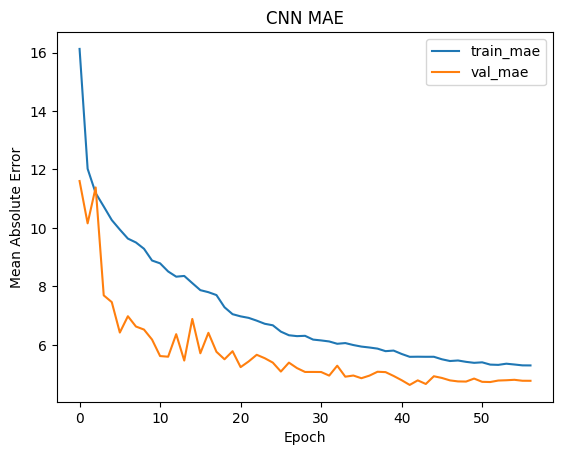

In [27]:
# -------------------------
# Ensemble
# -------------------------
ensemble_preds = (preds_cnn + preds_rf + preds_xgb) / 3.0
mae_ens = mean_absolute_error(y_test, ensemble_preds)
print("Ensemble (CNN+RF+XGB) MAE:", mae_ens)

# Save results
results = {
    'cnn': float(mae_cnn),
    'random_forest': float(mae_rf),
    'xgboost': float(mae_xgb),
    'ensemble': float(mae_ens)
}
pd.Series(results).to_csv("results_mae_summary.csv")
print("Results saved:", results)

# Save predictions
np.save("y_test.npy", y_test)
np.save("preds_cnn.npy", preds_cnn)
np.save("preds_rf.npy", preds_rf)
np.save("preds_xgb.npy", preds_xgb)
np.save("preds_ensemble.npy", ensemble_preds)

# Plot CNN training history
try:
    plt.figure()
    plt.plot(history.history['mean_absolute_error'], label='train_mae')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
    plt.legend()
    plt.title("CNN MAE")
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.savefig("cnn_mae_history.png")
except Exception as e:
    print("Plot error:", e)
